Импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
from sklearn.feature_selection import SelectKBest

%matplotlib inline

Загружаем данные из CSV. Данные преобразовываются в CSV с помощью утилиты `make_dataset`, которая собирается вместе с `SoFCheck`'ом

In [2]:
data = pd.read_csv('dataset.csv')

In [3]:
data

,winner,game_id,board_total,board_left,psq.cost.0,psq.cost.1,psq.cost.2,psq.cost.3,psq.cost.4,psq.cost.5,...,pawn_candidate,pawn_open,pawn_protected,pawn_backward,king_pawn.shield.0,king_pawn.shield.1,king_pawn.shield.2,king_pawn.shield.3,king_pawn.shield.4,king_pawn.shield.5
0,0.5,59122,162,139,0,0,0,0,0,0,...,0,256,0,0,0,235,235,235,0,0
1,0.0,73612,199,125,-256,0,0,0,0,0,...,0,-256,0,-256,0,0,0,0,0,0
2,0.0,25497,173,156,0,0,0,0,0,0,...,0,0,-512,0,-256,256,0,256,-256,0
3,1.0,78392,116,4,512,0,0,0,256,256,...,0,0,0,0,0,0,0,0,0,0
4,0.5,33722,128,38,-256,0,0,-256,256,0,...,0,-512,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,0.0,68843,141,59,-512,0,0,0,0,0,...,0,-256,-256,-256,0,0,0,0,0,0
2999996,0.0,48888,129,80,0,0,0,0,0,0,...,0,-256,-256,256,0,128,0,0,0,128
2999997,0.5,2035,213,106,-512,0,0,-256,256,0,...,0,0,0,0,0,0,0,0,0,0
2999998,1.0,64779,158,33,-512,0,0,0,256,0,...,0,0,0,-256,0,0,0,0,0,0


In [4]:
dv = data.values

Делим выборку на обучающую и тестовую. Деление осуществляем по `game_id`, чтобы позиции из одной игры не оказались в разных выборках.

In [5]:
games = np.array([i+1 for i in range(data['game_id'].max())])

games_train, games_test = train_test_split(games, test_size=0.1, shuffle=True)

In [6]:
train_set = set(games_train)
test_set = set(games_test)

is_train = np.vectorize(lambda x: x in train_set)
is_test = np.vectorize(lambda x: x in test_set)

dv_train = dv[is_train(dv[:,1])]
dv_test = dv[is_test(dv[:,1])]

In [7]:
del data
del dv

In [8]:
X = dv_train[:,4:]
y = dv_train[:,0]
w = dv_train[:,3]

X_test = dv_test[:,4:]
y_test = dv_test[:,0]
w_test = dv_test[:,3]

del dv_train
del dv_test

Ищем разброс значений (т.е. $\max - \min$) каждого из признаков. Это нам понадобится в дальнейшем для масштабирования:

In [9]:
std = np.max(X, axis=0) - np.min(X, axis=0)
std = np.maximum(np.min(std[std > 1e-9]), std)  # чтобы не допустить деления на ноль в дальнейшем
std

array([3584.,  256., 1024., 1024., 1280., 1536.,  256.,  256.,  256.,
        256.,  256.,  256.,  256.,  256.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  256.,
        256.,  256.,  256.,  256.,  256.,  256.,  256.,  299.,  341.,
        299.,  267.,  288.,  288.,  256.,  277.,  331.,  288.,  277.,
        288.,  320.,  330.,  320.,  266.,  288.,  362.,  309.,  320.,
        330.,  288.,  352.,  342.,  363.,  363.,  395.,  320.,  341.,
        373.,  384.,  363.,  384.,  395.,  427.,  427.,  426.,  416.,
        426.,  426.,  437.,  469.,  470.,  490.,  480.,  470.,  470.,
        501.,  470.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        501.,  512.,

Масштабируем признаки:

In [10]:
X /= std
X_test /= std

Создаем нашу модель. Здесь используется модель, описанная [на Хабре](https://habr.com/ru/post/305604/), только мы не пишем градиентный спуск руками, а используем силу PyTorch

In [11]:
model = nn.Sequential()
model.add_module('linear', nn.Linear(X.shape[1], 1, bias=False))
model.add_module('sigmoid', nn.Sigmoid())

In [12]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)

Определяем функцию потерь:

In [13]:
def get_loss(model, X, y, w, C=0.0):
    w = np.exp(-w / 32.)
    y_pred = model(X)[:, 0]
    assert y_pred.dim() == 1
    loss = torch.sum(w * ((y - y_pred) ** 2)) / torch.sum(w)
    loss += C * torch.norm(model.linear.weight, 2)
    return loss

Обучаем, пока не сойдется функция потерь. Для этого может быть полезно запустить ячейку несколько раз. А может быть, ее стоит остановить раньше.

In [14]:
C = 3e-5

history = []

for i in range(6000):
    # собираем батч
    indices = np.random.randint(0, X.shape[0], 16000)
    X_batch = torch.tensor(X[indices], dtype=torch.float32)
    y_batch = torch.tensor(y[indices], dtype=torch.float32)
    w_batch = torch.tensor(w[indices], dtype=torch.float32)
    
    # считаем функцию потерь
    loss = get_loss(model, X_batch, y_batch, w_batch, C=C)

    loss.backward()
    
    # надо раскомментить, если хочется менять только короля
    # model.linear.weight.grad[0, 0:6+64] = 0
    # model.linear.weight.grad[0, 6+64:6+384] = 0
    # model.linear.weight.grad[0, 6+448:] = 0
    
    # оптимизируем
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())

    # выводим результаты
    if i % 100 == 0:
        test_loss = get_loss(model,
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.float32),
            torch.tensor(w_test, dtype=torch.float32),
            C=0.0).detach().numpy().sum()
        train_loss = np.mean(history[-40:])
        print(f"step #{i}, train_loss = {train_loss:.4f}, test_loss = {test_loss:.4f}")

step #0, train_loss = 0.1636, test_loss = 0.1619
step #100, train_loss = 0.0919, test_loss = 0.0864
step #200, train_loss = 0.0754, test_loss = 0.0735
step #300, train_loss = 0.0688, test_loss = 0.0677
step #400, train_loss = 0.0655, test_loss = 0.0645
step #500, train_loss = 0.0635, test_loss = 0.0625
step #600, train_loss = 0.0616, test_loss = 0.0611
step #700, train_loss = 0.0607, test_loss = 0.0601
step #800, train_loss = 0.0602, test_loss = 0.0594
step #900, train_loss = 0.0595, test_loss = 0.0588
step #1000, train_loss = 0.0589, test_loss = 0.0584
step #1100, train_loss = 0.0588, test_loss = 0.0580
step #1200, train_loss = 0.0585, test_loss = 0.0576
step #1300, train_loss = 0.0582, test_loss = 0.0574
step #1400, train_loss = 0.0579, test_loss = 0.0571
step #1500, train_loss = 0.0579, test_loss = 0.0570
step #1600, train_loss = 0.0574, test_loss = 0.0568
step #1700, train_loss = 0.0573, test_loss = 0.0567
step #1800, train_loss = 0.0575, test_loss = 0.0566
step #1900, train_loss =

Смотрим на итоговое значение функции потерь на тестовом датасете:

In [15]:
test_loss = get_loss(model,
                     torch.tensor(X_test, dtype=torch.float32),
                     torch.tensor(y_test, dtype=torch.float32),
                     torch.tensor(w_test, dtype=torch.float32)).detach().numpy().sum()
test_loss

0.055755775

Ради интереса посмотрим на вероятности, которые предсказывает модель для каких-то $20$ соседних примеров тестовой выборки:

In [16]:
res = model(torch.tensor(X_test, dtype=torch.float32))[:, 0]

print(res[450:470], y_test[450:470])

tensor([0.5250, 0.9312, 0.6209, 0.5502, 0.8380, 0.5755, 0.2940, 0.1930, 0.6258,
        0.6274, 0.6658, 0.3043, 0.9999, 0.6369, 0.6405, 0.4452, 0.0643, 0.6232,
        0.4449, 0.6234], grad_fn=<SliceBackward>) [0.  1.  1.  0.  1.  0.5 1.  0.  0.  1.  0.5 1.  1.  1.  0.5 0.  0.  1.
 1.  1. ]


Теперь было бы неплохо преобразовать веса модели в коэффициенты, которые мы будем использовать в шахматной программе. Для этого нормируем таблицы фигура-поле так, чтобы медианное значение занулилось. Затем умножим все веса на одно и то же число так, чтобы стоимость пешки была равна `100` (т. е. одной пешке)

In [17]:
ws = (model.linear.weight[0]).detach().numpy() / std
for p in [0, 2, 3, 4, 5]:
    left = 6 + 64 * p
    right = 6 + 64 * (p + 1)
    if p == 0:
        # верхний и нижний ряд у пешки не используется, не обращаем на него внимание
        left += 8
        right -= 8
    m = np.median(ws[left:right])
    ws[left:right] -= m
    ws[p] += m

ww = (ws / ws[0] * 100).astype(np.int32)
print(ww)

[ 100    0  340  370  589 1059    0    0    0    0    0    0    0    0
  161  198  205  137  152  159  173  147   96   93   72   62   54   69
   78   74   22   18   -4    1   16    8    7    8   -8   -7  -12   -9
  -13    0   -7  -10  -11  -12  -13  -20  -13  -10  -10  -17  -10   -9
  -12  -47  -19    0   -1  -22    0    0    0    0    0    0    0    0
  199  220   64  185  129   97  138 -108  111  -81   19 -294   29    8
   -8 -188  -90 -130 -238 -284 -276 -106  -81 -197  -57  -21 -142 -156
  -71  -90  -96 -101   49   67  127   39   31   62  -10  -93    2   54
   69   98   47   47    0  -20   18   -5   27   23   17   33   69  110
 -162   -3   73  -43   51  -65   10   23  -75  -11   16   11  -20  -35
  -24  -88  -31    5   15   21   36   22    3  -68    0   13   33   30
   50   43   50  -14  -15    0   42   57   47   64   46   23  -38   -6
   21   18   39   37   37   22  -70  -24   -6    8   29   23    0  -13
  -60  -40   -9   -4  -10   -4   -7    6 -142  -73  -26  -37  -25  -17
   -2 

Эти веса уже можно скопировать, вставить в утилиту `apply_weigths` и использовать в `SoFCheck`'е.

Далее визуализируем полученные веса:

In [18]:
def display_mat(mat):
    plt.matshow(mat)
    for (x, y), value in np.ndenumerate(mat):
        plt.text(y, x, f"{value}", va="center", ha="center")

Стоимости фигур:

In [19]:
ww[:6]

array([ 100,    0,  340,  370,  589, 1059], dtype=int32)

Таблицы фигура-поле для пешки:

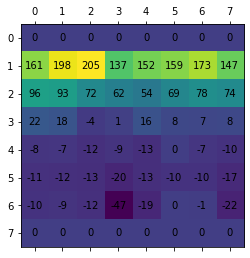

In [20]:
display_mat(ww[6:6+64].reshape(8, 8))

Таблицы фигура-поле для короля в миттельшпиле:

In [ ]:
display_mat(ww[6+64:6+128].reshape(8, 8))

Таблицы фигура-поле для коня:

In [ ]:
display_mat(ww[6+128:6+192].reshape(8, 8))

Таблицы фигура-поле для слона:

In [ ]:
display_mat(ww[6+192:6+256].reshape(8, 8))

Таблицы фигура-поле для ладьи:

In [ ]:
display_mat(ww[6+256:6+320].reshape(8, 8))

Таблицы фигура-поле для ферзя:

In [ ]:
display_mat(ww[6+320:6+384].reshape(8, 8))

Таблицы фигура-поле для короля в эндшпиле:

In [ ]:
display_mat(ww[6+384:6+448].reshape(8, 8))

Стоимость фигур, близких к вражескому королю, и стоимость двух слонов:

In [ ]:
ww[454], ww[455], ww[456]

Стоимость пешек: изолированная, двойная, проходная:

In [ ]:
ww[456], ww[457], ww[458]